# COMP0189: Applied Artificial Intelligence
## Week 7 (Dimensionality reduction and clustering)

Part 1: MNIST dataset  
Part 2: OASIS dataset  

### Acknowledgements
- https://scikit-learn.org/stable/
- https://oasis-brains.org

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

## Part 1: MNIST dataset: Principal Component Analysis and clustering in a latent space

**Task 1: Load MNIST data and assemble it in two matrices X (images) and y (labels)**

In [7]:
MNIST = np.load("../data/mnist.npz")
for k in MNIST.files:
    print(k)

X
y


<IPython.core.display.Javascript object>

In [8]:
MNIST["X"].shape, MNIST["y"].shape

((60000, 28, 28), (60000,))

<IPython.core.display.Javascript object>

In [9]:
mnist_X = MNIST["X"]
mnist_y = MNIST["y"]

<IPython.core.display.Javascript object>

**Task 2: Visualise the data for better understanding**

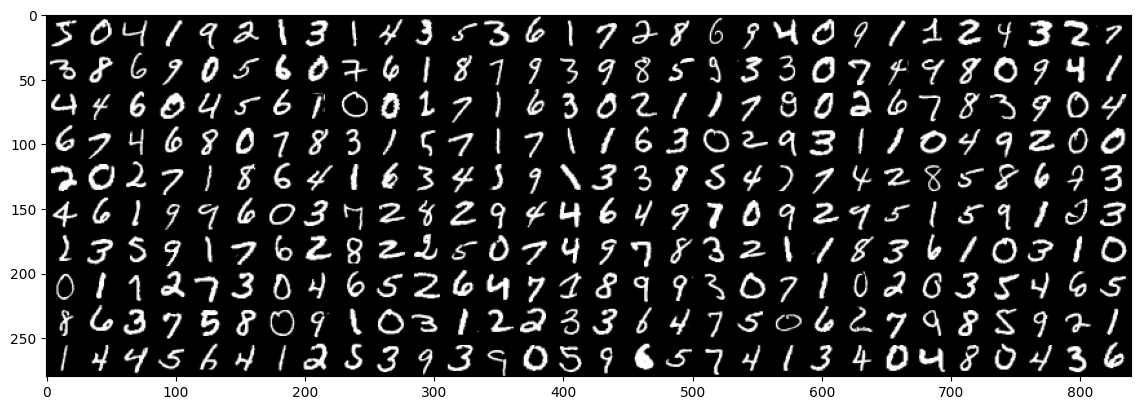

<IPython.core.display.Javascript object>

In [10]:
def make_img_grid(images, n_cols=10):
    """Helper function for arranging images into a grid"""
    cols = []
    gap = len(images) % n_cols
    if gap > 0:
        # add padding if needed
        images = np.concatenate(
            (images, np.zeros((n_cols - gap,) + images[0].shape)), 0
        )
    for n in range(n_cols):
        cols.append(np.concatenate(images[np.arange(n, len(images), step=n_cols)]))
    return np.concatenate(cols, -1)


plt.figure(figsize=(14, 7))
plt.imshow(make_img_grid(mnist_X[:300], n_cols=30), cmap="binary_r")

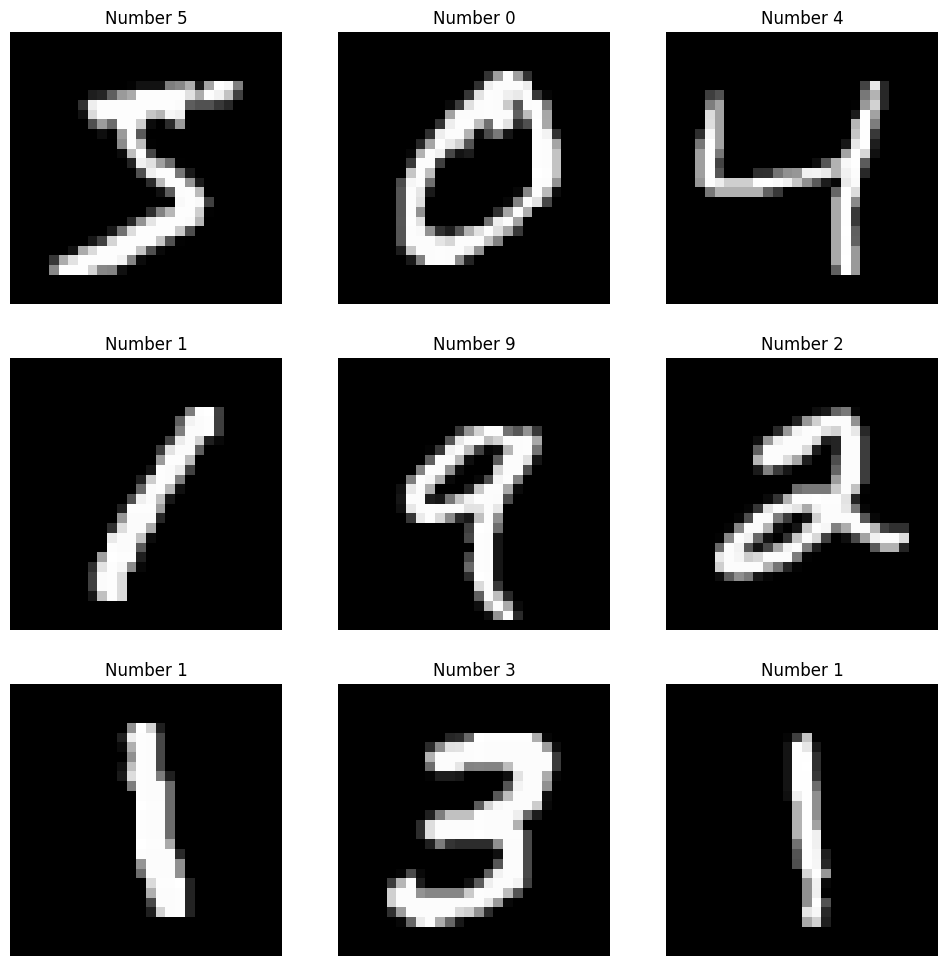

<IPython.core.display.Javascript object>

In [11]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
plt.gray()

# loop through subplots and add mnist images
for i, ax in enumerate(axs.flat):
    ax.imshow(mnist_X[i])
    ax.axis("off")
    ax.set_title("Number {}".format(mnist_y[i]))

# display the figure
plt.show()

#### Pre-processing the data

One challenge with K-means is that it can be slow to find the nearest cluster centers for each datapoint. This is particularly for high dimensional data (or for large K).

An easy way to speed things up is to pre-process the data by reducing its dimensionality.

Here, we will run PCA as pre-processing. The next cells reshape the original MNIST data, from

* `mnist_images.shape == [60000, 28, 28]`

into a 2d array (matrix)

* `X_mnist.shape == [60000, 784]`

In [12]:
# Reshaping
mnist_X_original = mnist_X.copy()
mnist_X = mnist_X.reshape(len(mnist_X), -1)
print(mnist_X.shape)

(60000, 784)


<IPython.core.display.Javascript object>

**Task 3: Apply PCA to the MNIST data**

In [13]:
from sklearn.decomposition import PCA

pca = PCA()
mnist_X_pca = pca.fit_transform(mnist_X)

<IPython.core.display.Javascript object>

In [14]:
mnist_X_pca.shape

(60000, 784)

<IPython.core.display.Javascript object>

**Task 4: Plot the MNIST data projected onto the first two principal components (using different colours for the different digits). Use the labels to colour the examples**

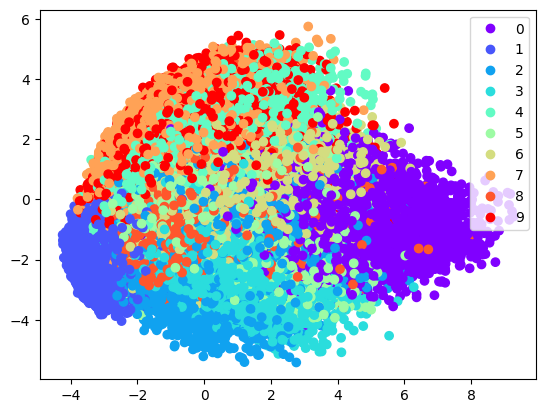

<IPython.core.display.Javascript object>

In [15]:
plot = plt.scatter(mnist_X_pca[:, 0], mnist_X_pca[:, 1], c=mnist_y, cmap="rainbow")
plt.legend(handles=plot.legend_elements()[0], labels=[x for x in range(10)])
plt.show()

**Task 5: Plot the explained variance per component. Based on the plot decide on how many components should be used for clustering**

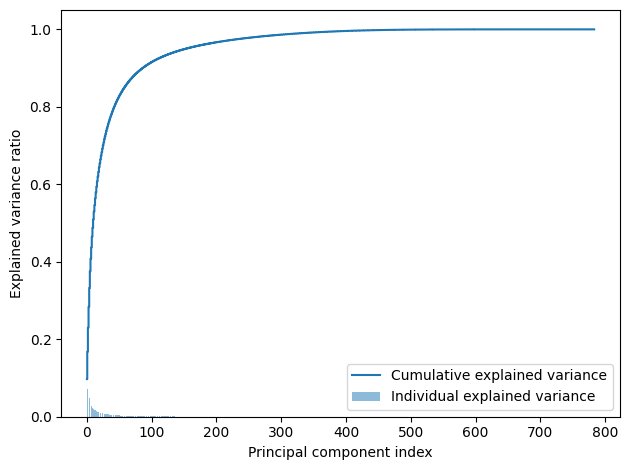

<IPython.core.display.Javascript object>

In [16]:
# Determine explained variance using explained_variance_ratio_ attribute
# explained_variance_ratio_
#   Percentage of variance explained by each of the selected components.
#   If n_components is not set then all components are stored and the sum of the ratios is equal to 1.0.
exp_var_pca = pca.explained_variance_ratio_  # shape: (784,)

# Cumulative sum of eigenvalues will be used to create step plot
# for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the plot
plt.bar(
    range(0, len(exp_var_pca)),
    exp_var_pca,
    alpha=0.5,
    align="center",
    label="Individual explained variance",
)
plt.step(
    range(0, len(cum_sum_eigenvalues)),
    cum_sum_eigenvalues,
    where="mid",
    label="Cumulative explained variance",
)
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal component index")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [17]:
# Manual way of gettting explained variance

<IPython.core.display.Javascript object>

In [18]:
def compute_PCA_parameters(X, M):
    """
    This function computes the first M prinicpal components of a
    dataset X. It returns the mean of the data, the projection matrix,
    and the associated singular values.

    While you can compute this however you want, `np.linalg.svd` is
    highly recommended. Please look at its documentation to choose
    its arguments appropriately, and on how to interpret its return values.

    INPUT:
    X    : (N, D) matrix; each row is a D-dimensional data point
    M    : integer, <= D (number of principal components to return)

    OUTPUTS:
    x_bar  : (D,) vector, with the mean of the data
    W      : (D, M) semi-orthogonal matrix of projections
    s      : (D,) vector of singular values
    """
    N, D = X.shape
    x_bar = np.mean(X, 0)
    X_bar = X - x_bar
    u, s, vh = np.linalg.svd(X_bar, full_matrices=False)
    W = vh.T[:, :M]
    return x_bar, W, s

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Explained variance')

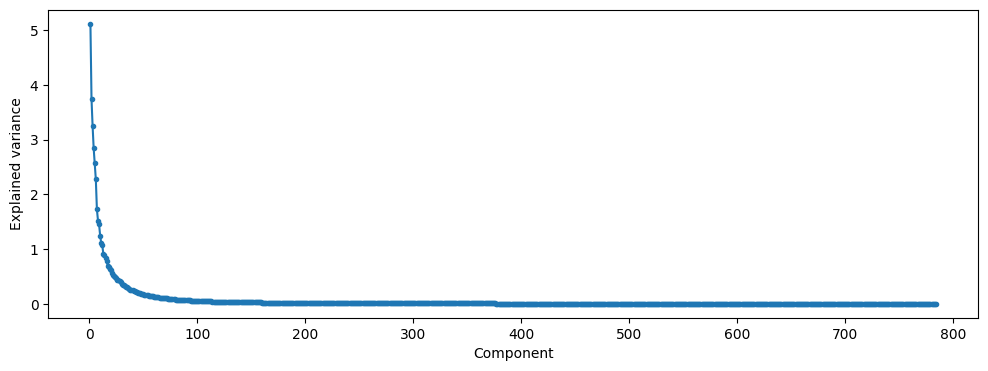

<IPython.core.display.Javascript object>

In [19]:
mnist_mean, W_mnist, s_mnist = compute_PCA_parameters(mnist_X, 50)

N, data_dim = mnist_X.shape
plt.figure(figsize=(12, 4))
plt.plot(np.arange(data_dim) + 1, s_mnist**2 / N, ".-")
plt.xlabel("Component")
plt.ylabel("Explained variance")

**Task 6: Apply KMeans to PCA-reduced data**

In [20]:
# Apply PCA of 200 components
pca = PCA(n_components=200)
mnist_X_pca = pca.fit_transform(mnist_X)

<IPython.core.display.Javascript object>

In [21]:
# Perform KMeans
from sklearn.cluster import KMeans

n_digits = len(np.unique(mnist_y))
print(n_digits)

10


<IPython.core.display.Javascript object>

In [22]:
%%time

kmeans = KMeans(n_clusters=n_digits, n_init=10)
kmeans.fit(mnist_X_pca)

CPU times: user 24.3 s, sys: 4.72 s, total: 29 s
Wall time: 4.7 s


KMeans(n_clusters=10, n_init=10)

<IPython.core.display.Javascript object>

In [24]:
kmeans.labels_

array([1, 7, 2, ..., 1, 6, 6], dtype=int32)

<IPython.core.display.Javascript object>

**Task 7: Visualise example of the clusters**

In [25]:
make_img_grid(mnist_X_original[:200], n_cols=40).shape

(140, 1120)

<IPython.core.display.Javascript object>

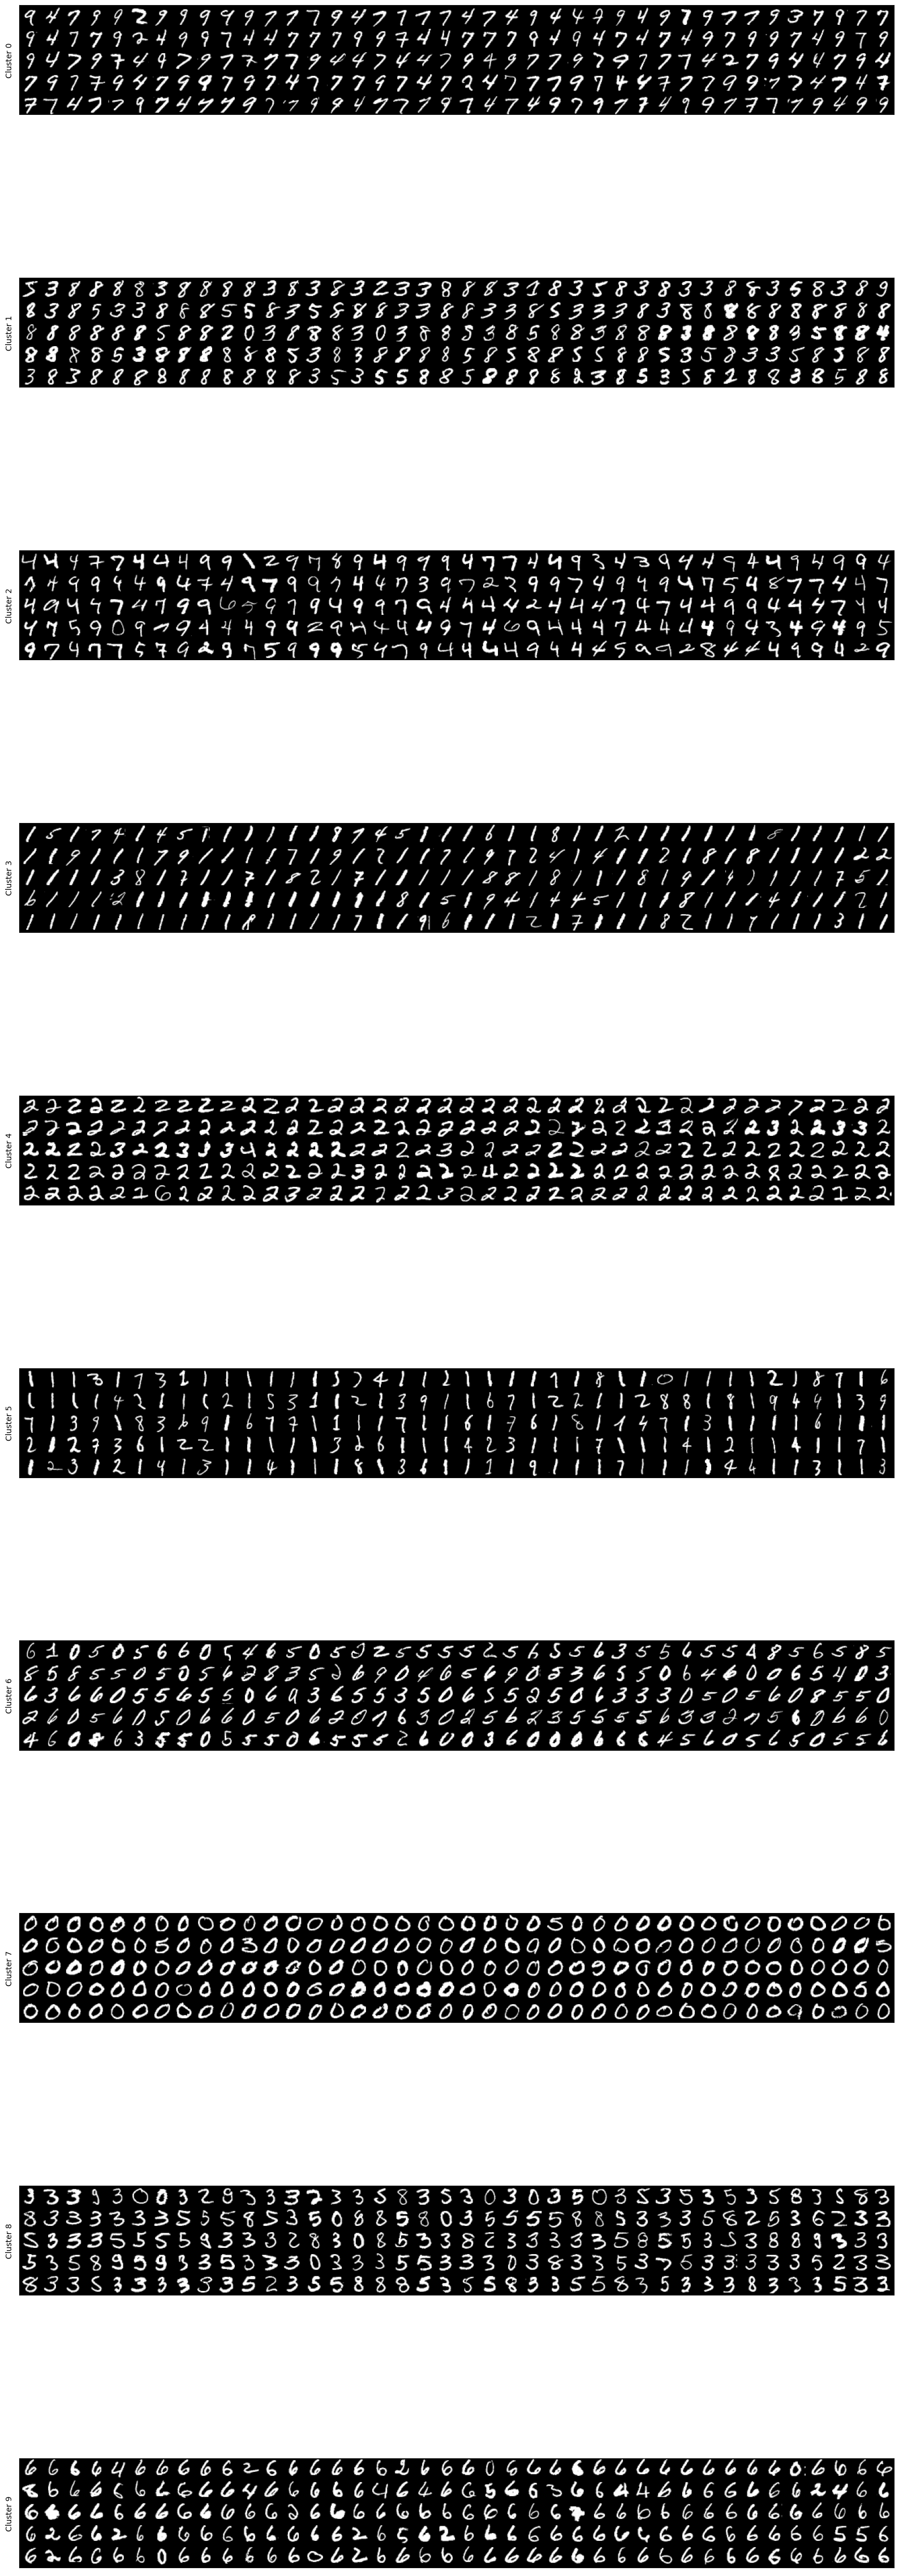

<IPython.core.display.Javascript object>

In [26]:
plt.figure(figsize=(16, 50))
for k in range(10):
    plt.subplot(10, 1, k + 1)
    plt.imshow(
        make_img_grid(mnist_X_original[kmeans.labels_ == k][:200], n_cols=40).reshape(
            140, 1120
        ),
        cmap="binary_r",
    )
    plt.xticks([])
    plt.yticks([])
    plt.ylabel("Cluster %d" % (k))
plt.tight_layout()

**Task 8: Evaluate**

In [27]:
def retrieve_info(cluster_labels, y_train):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """
    # Initializing
    reference_labels = {}
    # For loop to run through each label of cluster label
    for i in range(len(np.unique(kmeans.labels_))):
        index = np.where(cluster_labels == i, 1, 0)
        num = np.bincount(y_train[index == 1]).argmax()
        reference_labels[i] = num
    return reference_labels

<IPython.core.display.Javascript object>

In [28]:
reference_labels = retrieve_info(kmeans.labels_, mnist_y)

<IPython.core.display.Javascript object>

In [29]:
reference_labels

{0: 7, 1: 8, 2: 4, 3: 1, 4: 2, 5: 1, 6: 6, 7: 0, 8: 3, 9: 6}

<IPython.core.display.Javascript object>

In [30]:
number_labels = np.random.rand(len(kmeans.labels_))
for i in range(len(kmeans.labels_)):
    number_labels[i] = reference_labels[kmeans.labels_[i]]

<IPython.core.display.Javascript object>

In [31]:
number_labels.shape

(60000,)

<IPython.core.display.Javascript object>

In [32]:
from sklearn import metrics


# Define a function to calculate and print accuracy, precision and recall scores
def evaluate(labels_true, labels_pred):
    accuracy = metrics.accuracy_score(labels_true, labels_pred)
    precision = metrics.precision_score(
        labels_true, labels_pred, average="macro", zero_division=0
    )
    recall = metrics.recall_score(
        labels_true, labels_pred, average="macro", zero_division=0
    )
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}\n")

<IPython.core.display.Javascript object>

In [33]:
evaluate(mnist_y, number_labels)

Accuracy: 0.58
Precision: 0.50
Recall: 0.57



<IPython.core.display.Javascript object>

In [34]:
# Practical purpose: try minibatch kmeans for better computation time.
# But do you get better performance?
# https://scikit-learn.org/stable/modules/clustering.html#mini-batch-kmeans
from sklearn.cluster import MiniBatchKMeans

<IPython.core.display.Javascript object>

In [35]:
%%time

kmeans = MiniBatchKMeans(n_clusters=n_digits, n_init=10)
kmeans.fit(mnist_X_pca)

CPU times: user 1.28 s, sys: 489 ms, total: 1.77 s
Wall time: 374 ms


MiniBatchKMeans(n_clusters=10, n_init=10)

<IPython.core.display.Javascript object>

### `silhouette_score` and Evaluation Benchmark for  KMeans

In [36]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(model, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    model
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    # can add your own pipeline, but we just use our model here
    estimator = make_pipeline(model).fit(data)
    fit_time = time() - t0

    reference_labels = retrieve_info(estimator[-1].labels_, labels)
    number_labels = np.random.rand(len(estimator[-1].labels_))
    for i in range(len(estimator[-1].labels_)):
        number_labels[i] = reference_labels[estimator[-1].labels_[i]]

    # inertia_: Sum of squared distances of samples to their closest cluster center,
    #           weighted by the sample weights if provided.
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, number_labels) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # traditional metrics with true labels
    results += [
        metrics.accuracy_score(labels, number_labels),
        metrics.precision_score(
            labels, number_labels, average="macro", zero_division=0
        ),
        metrics.recall_score(labels, number_labels, average="macro", zero_division=0),
    ]

    # Show the results
    formatter_result = "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    print(formatter_result.format(*results))

<IPython.core.display.Javascript object>

In [38]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(100 * "_")
print("model\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilh\taccu\tprec\trecall")

model = KMeans(n_clusters=n_digits, n_init=10, random_state=0)
bench_k_means(model=model, name="kmeans", data=mnist_X, labels=mnist_y)

model = MiniBatchKMeans(n_clusters=n_digits, n_init=10, random_state=0)
bench_k_means(model=model, name="minibatch", data=mnist_X, labels=mnist_y)

# change n_components of pca
pca = PCA(n_components=2)
mnist_X_pca = pca.fit_transform(mnist_X)
model = KMeans(n_clusters=n_digits, n_init=10, random_state=0)
bench_k_means(model=model, name="PCA-kmeans", data=mnist_X_pca, labels=mnist_y)

pca = PCA(n_components=2)
mnist_X_pca = pca.fit_transform(mnist_X)
model = MiniBatchKMeans(n_clusters=n_digits, n_init=10, random_state=0)
bench_k_means(model=model, name="PCA-minibatch", data=mnist_X_pca, labels=mnist_y)

print(100 * "_")

____________________________________________________________________________________________________
model		time	inertia	homo	compl	v-meas	ARI	AMI	silh	accu	prec	recall
kmeans   	17.190s	2352828	0.481	0.542	0.510	0.405	0.509	0.067	0.591	0.502	0.580
minibatch	0.903s	2387217	0.405	0.490	0.444	0.325	0.444	0.058	0.505	0.373	0.496
PCA-kmeans	0.515s	59008	0.336	0.412	0.370	0.268	0.370	0.308	0.408	0.295	0.397
PCA-minibatch	0.073s	60723	0.302	0.362	0.330	0.234	0.329	0.328	0.403	0.275	0.392
____________________________________________________________________________________________________


<IPython.core.display.Javascript object>

## Part 2: OASIS dataset: Cross decomposition methods and clustering in the latent space

In this part, you will learn how to apply cross decomposition methods such as CCA and PLSSVD to find the fundamental relations between two matrices (X and Y) that represent different views of the same data. You will also learn how to use KMeans clustering to group the data points based on their latent representations in a lower-dimensional space.

We will use the OASIS dataset, which contains brain MRI images (view 1) and clinical assessments (view 2) of 416 subjects aged 18 to 96. The goal is to explore how these two views are related and how they can be used for clustering.

## Import libraries and load data

First, we need to import some libraries and load the data from CSV files.

In [45]:
from sklearn.cross_decomposition import CCA, PLSSVD
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


labels = pd.read_csv("../data/OASIS_labels.csv")
brain_roi = pd.read_csv("../data/OASIS_view1_ROI.csv")
clinical = pd.read_csv("../data/OASIS_view2_clinical.csv")

<IPython.core.display.Javascript object>

## Data preprocessing

Next, we need to do some preprocessing on the data. We will drop some columns that are not relevant for our analysis, such as subject ID, gender, handness, etc. We will also normalize each view by subtracting its mean and dividing by its standard deviation.

In [46]:
# Drop irrelevant columns
brain_roi = brain_roi.drop(["Subject ID"], axis=1)
clinical = clinical.drop(["Subject ID", "Gender"], axis=1)

# Fill nans with mean values
brain_roi = brain_roi.fillna(brain_roi.mean(numeric_only=True))
clinical = clinical.fillna(clinical.mean(numeric_only=True))

# Normalize each view
brain_roi = (brain_roi - brain_roi.mean(numeric_only=True)) / brain_roi.std(
    numeric_only=True
)
clinical = (clinical - clinical.mean(numeric_only=True)) / clinical.std(
    numeric_only=True
)

<IPython.core.display.Javascript object>

In [47]:
brain_roi

,ROI_1,ROI_2,ROI_3,ROI_4,ROI_5,ROI_6,ROI_7,ROI_8,ROI_9,ROI_10,...,ROI_107,ROI_108,ROI_109,ROI_110,ROI_111,ROI_112,ROI_113,ROI_114,ROI_115,ROI_116
0,1.171089,0.953055,1.486102,1.890034,1.521017,2.277301,1.226812,1.998257,1.062506,1.793378,...,1.109843,-0.353631,0.579487,0.854951,2.114570,2.097078,1.867884,1.901696,2.845956,1.723914
1,-0.291822,0.345927,0.175070,0.604458,-1.096939,-0.812574,-0.456608,0.013837,-1.544411,-1.413938,...,0.625547,0.411880,0.245336,0.477758,1.801527,1.126550,1.057249,1.756853,1.597863,1.006938
2,-0.540888,-0.303252,0.488525,-0.530245,0.259578,-0.431357,0.189021,-0.040192,-0.212131,-0.114031,...,0.055959,-0.270306,1.489646,0.787153,-0.066560,0.345500,0.917178,1.131991,1.184418,1.765684
3,0.047324,0.641759,0.449664,0.871454,0.789032,0.622948,0.756943,0.560856,0.678268,0.675193,...,-0.440730,0.608688,-0.252194,-0.916529,-0.835492,-0.214504,-0.861118,-0.793980,0.298061,-0.941311
4,-0.720035,-0.686748,-0.739441,-1.099923,-0.577816,-0.873258,-0.703614,-1.130254,-0.259492,-0.778182,...,-0.177468,-0.769119,-0.795680,-1.469126,-1.740389,-1.805986,-1.622664,-1.734055,-1.678306,-1.119279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.138245,0.319408,0.024540,-0.277391,0.899568,0.859549,0.027746,0.857978,0.338965,0.373900,...,1.586373,1.502122,0.901184,1.089479,1.926993,2.557885,2.721102,1.736783,1.177663,1.298958
96,-1.354786,-0.953049,-1.100355,-1.198335,-1.186781,-1.467902,-1.499551,-1.549281,-1.435084,-0.777102,...,-0.324040,0.310927,1.187029,1.014072,0.399560,0.099108,0.782017,-0.058909,-0.418342,0.481298
97,-0.417146,-0.574432,0.052970,-0.562129,-0.313647,-0.349258,-0.310019,-0.544687,-0.440912,-0.237537,...,-1.722928,-1.017212,-0.202207,0.317829,0.646472,0.584354,0.566224,0.712973,0.926149,0.987858
98,0.674451,0.858392,-0.819202,0.392182,-0.183760,-0.081280,0.401484,0.782845,0.130378,0.102635,...,-1.560960,-0.034026,-0.677044,-1.179881,-1.440503,-1.155371,-0.828522,-1.400471,-0.868932,-0.597222


<IPython.core.display.Javascript object>

In [48]:
clinical

,Age,EDUC,MMSE,CDR
0,1.721720,-0.109644,-0.111385,-0.896937
1,0.687210,-0.817023,0.216218,-0.896937
2,-0.642874,0.597735,0.216218,0.573452
3,-1.381810,-0.817023,0.871425,0.573452
4,0.834997,-0.817023,0.871425,-0.896937
...,...,...,...,...
95,-1.086236,-0.109644,-0.438989,-0.896937
96,-0.199513,-0.817023,-0.438989,0.573452
97,-1.381810,-0.463333,0.871425,-0.896937
98,-0.495087,0.597735,-1.094196,0.573452


<IPython.core.display.Javascript object>

## Cross decomposition methods

Now we are ready to apply cross decomposition methods to find the relations between the two views. We will use two methods: CCA and PLSSVD.

CCA finds linear combinations of X and Y that have maximum correlation1. It can be seen as a generalization of PCA for two sets of variables.

PLSSVD finds linear combinations of X and Y that have maximum covariance. It can be seen as a generalization of SVD for two sets of variables.

For both methods, we need to specify the number of components (n_components) that we want to extract from each view. This parameter controls the dimensionality of the latent space where we will cluster the data points later.

We will use n_components=2 for both methods. You can try different values later and see how they affect the results.

For further comparison, apply PCA to the brain_roi data with 2 components in order to see if combining the modalities improves the latent space.

### CCA Fitting

In [49]:
CCA_n_components = 2
# Create CCA object with n_components=2
cca = CCA(n_components=CCA_n_components)

# Fit CCA model on X (brain_roi) and Y (clinical)
cca.fit(brain_roi, clinical)

# Transform X and Y into their latent representations using CCA
X_c, Y_c = cca.transform(brain_roi, clinical)

<IPython.core.display.Javascript object>

In [50]:
X_c.shape, Y_c.shape

((100, 2), (100, 2))

<IPython.core.display.Javascript object>

### CCA Plotting

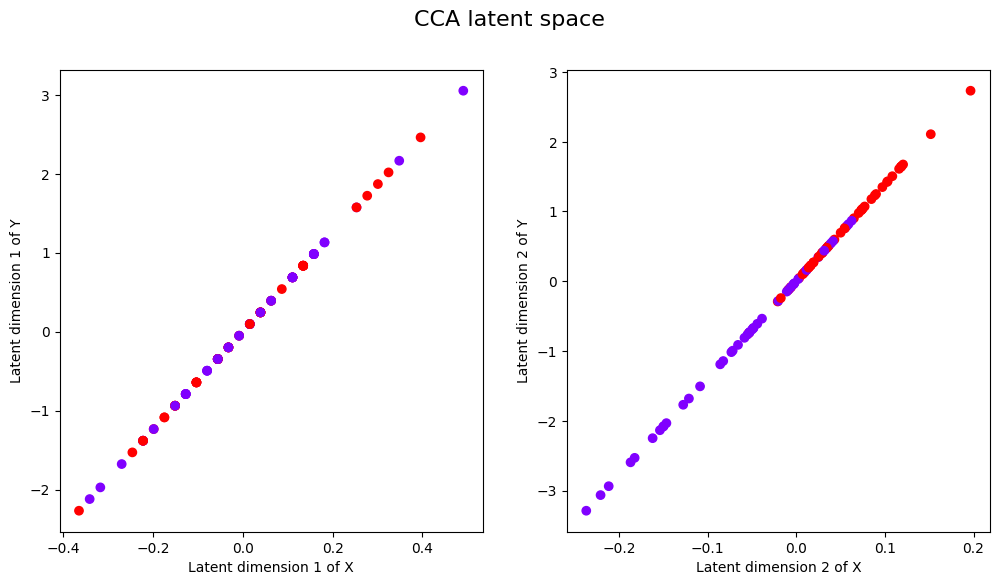

<IPython.core.display.Javascript object>

In [51]:
# Convert labels to numbers
label_dict = {"Demented": 0, "Nondemented": 1}
label_nums = labels["Group"].map(label_dict)

# Plot the latent dimensions for CCA
fig, axes = plt.subplots(1, CCA_n_components, figsize=(12, 6))
for i in range(CCA_n_components):
    axes[i].scatter(X_c[:, i], Y_c[:, i], c=label_nums, cmap="rainbow")
    axes[i].set_xlabel(f"Latent dimension {i+1} of X")
    axes[i].set_ylabel(f"Latent dimension {i+1} of Y")
fig.suptitle("CCA latent space", fontsize=16)
plt.show()

### PLS

In [52]:
PLSSVD_n_components = 2
# Create PLSSVD object with n_components=3
plssvd = PLSSVD(n_components=PLSSVD_n_components)

# Fit PLSSVD model on X (brain_roi) and Y (clinical)
plssvd.fit(brain_roi, clinical)

# Transform X and Y into their latent representations using PLSSVD
X_p, Y_p = plssvd.transform(brain_roi, clinical)

<IPython.core.display.Javascript object>

### PLS Plotting

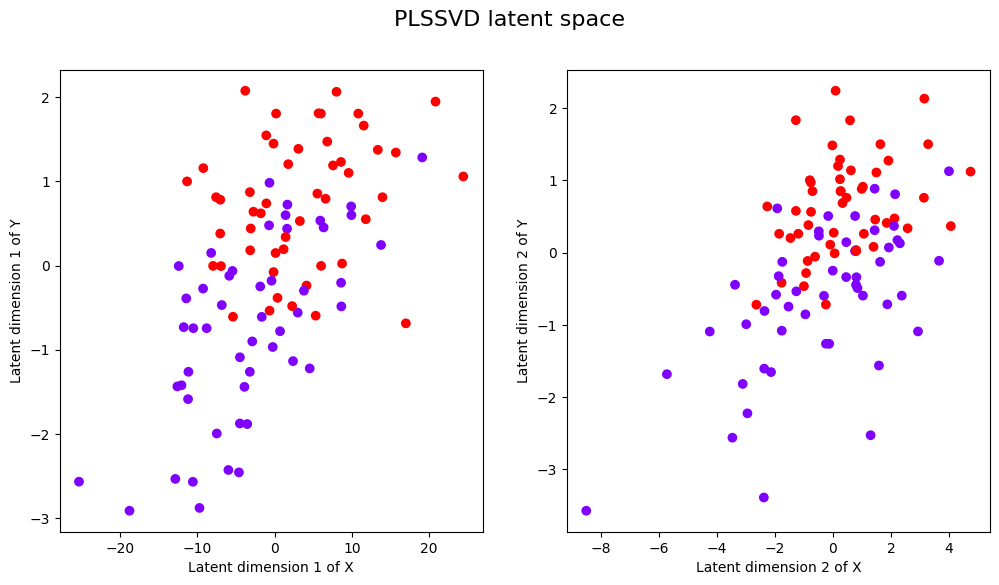

<IPython.core.display.Javascript object>

In [53]:
# Plot the latent dimensions for PLSSVD
fig, axes = plt.subplots(1, PLSSVD_n_components, figsize=(12, 6))
for i in range(PLSSVD_n_components):
    axes[i].scatter(X_p[:, i], Y_p[:, i], c=label_nums, cmap="rainbow")
    axes[i].set_xlabel(f"Latent dimension {i+1} of X")
    axes[i].set_ylabel(f"Latent dimension {i+1} of Y")
fig.suptitle("PLSSVD latent space", fontsize=16)
plt.show()

## PCA

In [54]:
# Perform PCA on brain_roi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(brain_roi)

<IPython.core.display.Javascript object>

### PCA Plotting

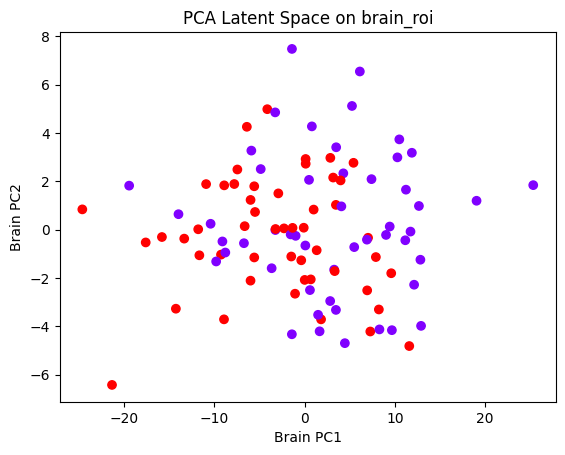

<IPython.core.display.Javascript object>

In [55]:
# Plot brain principal components as a scatter plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=label_nums, cmap="rainbow")
plt.xlabel("Brain PC1")
plt.ylabel("Brain PC2")
plt.title("PCA Latent Space on brain_roi")
plt.show()

In [56]:
# Perform PCA on clinical variables
pca = PCA(n_components=2)
Y_pca = pca.fit_transform(clinical)

<IPython.core.display.Javascript object>

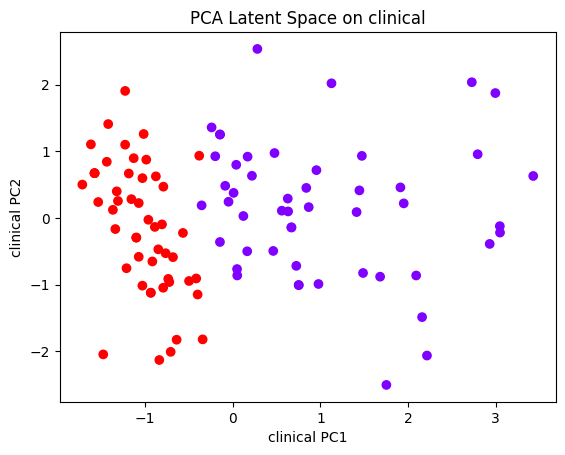

<IPython.core.display.Javascript object>

In [57]:
# Plot clinical principal components as a scatter plot
plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c=label_nums, cmap="rainbow")
plt.xlabel("clinical PC1")
plt.ylabel("clinical PC2")
plt.title("PCA Latent Space on clinical")
plt.show()

## Clustering in the latent space

Finally, we will use KMeans clustering to group the data points based on their latent representations obtained from CCA, PLSSVD, and PCA. For CCA and PLSSVD we will average or add the X_c/Y_c and X_p/Y_p respectively while for PCA we will just use X_pca. We will use n_clusters=2 for KMeans, which corresponds to two groups: Non-Demented (ND) and Demented (D).

In [58]:
# Create KMeans object with n_clusters=3
kmeans = KMeans(n_clusters=2, n_init=10)

# Cluster the data points based on their latent representations from CCA
kmeans.fit(X_c + Y_c)
labels_c = kmeans.labels_

# Cluster the data points based on their latent representations from PLSSVD
kmeans.fit(X_p + Y_p)
labels_p = kmeans.labels_

# Cluster the data points based on their latent representations from PCA brain_roi
kmeans.fit(X_pca)
labels_brain = kmeans.labels_

<IPython.core.display.Javascript object>

## Quantify Performance of K-Means classifiers using the different latent spaces
NOTE You may need to reverse the sign on the kmeans labels if accuracy is below 0.5 for any model since k-means does not know the order of the original labels.


In [59]:
# Import metrics module from sklearn
from sklearn import metrics


# Define a function to calculate and print accuracy, precision and recall scores
def evaluate(labels_true, labels_pred):
    accuracy = metrics.accuracy_score(labels_true, labels_pred)
    precision = metrics.precision_score(labels_true, labels_pred)
    recall = metrics.recall_score(labels_true, labels_pred)
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}\n")


# Compare the performance of classifiers based on CCA, PLSSVD, PCA brain_roi and PCA clinical
# assuming true_labels is a variable that stores the ground truth labels
print("Performance of classifier based on CCA:")
evaluate(label_nums, labels_c)
print("Performance of classifier based on PLSSVD:")
evaluate(label_nums, labels_p)
print("Performance of classifier based on PCA brain_roi:")
evaluate(label_nums, labels_brain)

Performance of classifier based on CCA:
Accuracy: 0.75
Precision: 0.68
Recall: 0.96

Performance of classifier based on PLSSVD:
Accuracy: 0.65
Precision: 0.67
Recall: 0.60

Performance of classifier based on PCA brain_roi:
Accuracy: 0.63
Precision: 0.68
Recall: 0.50



<IPython.core.display.Javascript object>

## Conclusion
This week you learned how to apply cross decomposition methods such as CCA and PLSSVD to find the relations between two views of the same data. You also learned how to use KMeans clustering to group the data points based on their latent representations in a lower-dimensional space.

You can experiment with different values of n_components and n_clusters and see how they affect the results. You can also try other cross decomposition methods such as PLSRegression or PLSCanonical or other clustering methods such as DBSCAN or SpectralClustering.